In [ ]:
%matplotlib widget

In [25]:
import pathlib
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm.notebook import tqdm

In [26]:
tsv_path = pathlib.Path('/home/aaron/Documents/research/kumar/ipa_gpt/rus-pol-errors.tsv')

## File Data

In [27]:
with open(tsv_path) as fp:
    lines = fp.read().splitlines(keepends=False)
    lines = [l.split('\t') for l in lines]
headers = lines.pop(0)
print(headers)

['eval_lang', 'model_type', 'rowid', 'gold_indices', 'gold_input_string', 'gold_answer_text', 'gold_answer_character_start', 'character_index_mapping', 'answer_indices', 'answer_character_start', 'answer_confidence_score', 'answer_text', 'answer_start_logits', 'answer_end_logits']


In [28]:
print(lines[0])

['russian', 'normal', '63271', '(34, 37)', '<|endoftext|> Сколько лет происходит развитие мозговой массы? <|endoftext|> Головной мозг человека расположен в мозговом отделе черепа. Средняя его масса 1300—1400 г. Рост мозга продолжается до 20 лет. Состоит он из 5-ти отделов: переднего, промежуточного, среднего, заднего и продолговатого мозга. Внутри головного мозга находятся 4 сообщающиеся между собой полости — мозговые желудочки. Они заполнены спинномозговой жидкостью. Филогенетически более древняя часть — ствол головного мозга. Ствол включает продолговатый мозг, варолиев мост, средний и промежуточный мозг. 12 пар черепных нервов лежат в стволе мозга. Стволовая часть мозга прикрыта полушариями головного мозга. <|endoftext|>', 'до 20 лет.', '191', '[[0, 13], [13, 21], [21, 25], [25, 36], [36, 45], [45, 50], [50, 54], [54, 60], [60, 61], [61, 62], [62, 75], [75, 81], [81, 84], [84, 89], [89, 98], [98, 109], [109, 111], [111, 116], [116, 120], [120, 127], [127, 134], [134, 135], [135, 143]

### Construct Error Data Dict

In [29]:
def parse_offset_mapping(s: str) -> List[Tuple[int, int]]:
    s = s[1:-1]
    chunks = s.split('], [')
    chunks[0] = chunks[0][1:]
    chunks[-1] = chunks[-1][:-1]
    return [
        tuple(map(int, c.split(', '))) for c in chunks
    ]


def parse_tuple(s: str) -> Tuple[int, int]:
    ss, se = s.split(', ')
    return int(ss[1:]), int(se[:-1])


def parse_logit_array(s: str) -> List[float]:
    c = s[1:-1].split(', ')
    return list(map(float, c))


def parse_string(s: str) -> str:
    return s.replace('<tab_place_holder>', '\t').replace('<newline_place_holder>', '\n')


def parse_error_row(row: List[str]) -> list:
    assert(len(row) == 14)
    return [
        row[0],
        row[1],
        row[2],
        parse_tuple(row[3]),
        parse_string(row[4]),
        parse_string(row[5]),
        int(row[6]),
        parse_offset_mapping(row[7]),
        parse_tuple(row[8]),
        int(row[9]),
        float(row[10]),
        parse_string(row[11]),
        parse_logit_array(row[12]),
        parse_logit_array(row[13]),
    ]

In [30]:
parsed_rows = [parse_error_row(r) for r in tqdm(lines)]

  0%|          | 0/2714 [00:00<?, ?it/s]

Error, less than 14 elements: ['polish', 'normal', '291', '(125, 129)', '<|endoftext|> Połączeniem jakich kolorów jest szara tęczówka? <|endoftext|> Szare oczy, podobnie jak oczy niebieskie i zielone, posiadają melaninę w tylnej części tęczówki, podczas gdy przednia część tęczówki zawiera znikome jej ilości. Szary kolor oka podobny jest nieco do barwy niebieskiej, jednak szara tęczówka posiada większe ilości kolagenu, przez co światło zostaje w niej rozszczepione w inny sposób niż w tęczówce niebieskiej. Uwzględniając biologiczne aspekty kolorów oka, barwa szara jest barwą wypadkową niebieskiego i zielonego koloru oczu. Jednocześnie sugeruje się, że oczy szare, oraz niebieskie mogą mieć różne zawartości melaniny, niezależnie od barwy. Gdy tęczówka barwy szarej widziana jest w powiększeniu, wykazuje niekiedy tendencję do posiadania bardzo niewielkich ilości barw żółtej i brązowej w przedniej części tęczówki.']


IndexError: list index out of range

In [ ]:
error_data = {
    'polish': {
        'ipa': {},
        'normal': {}
    },
    'russian': {
        'ipa': {},
        'normal': {}
    }
}
for error in parsed_rows:
    error_data[error[0]][error[1]][error[2]] = error[3:]

In [3]:
def plot_lines(ax, row: list, start: bool = True):
    ax.plot(range(len(row[12 + int(not start)])), row[12 + int(not start)], label=f'logits', color='red')
    ax.axvline(x=row[8][int(not start)], zorder=3, color='red', linestyle='--', linewidth=2, label='predicted')
    ax.axvline(x=row[3][int(not start)], zorder=3, color='cyan', linestyle='--', linewidth=2, label='correct answer')
    # ax.legend()

# Start Logits

### Russian

#### Normal

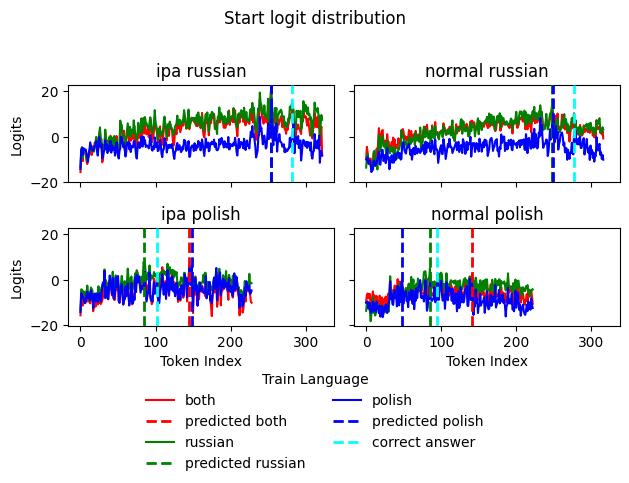

In [4]:
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.15)

ax.set_ylabel('Logits')
ax.set_xlabel('Token Index')

keys = list(error_data['russian']['normal'].keys())
x_range = max(map(len, [error_data['russian']['normal'][k][12] for k in keys]))
ax.set_title(f'Row: {keys[0]}')
row = error_data['russian']['normal'][keys[0]]
line, = ax.plot(range(x_range), row[12], label=f'logits', color='red')
ax.axvline(x=row[8][0], zorder=3, color='red', linestyle='--', linewidth=2, label='predicted')
ax.axvline(x=row[3][0], zorder=3, color='cyan', linestyle='--', linewidth=2, label='correct answer')

# Create slider
ax_slider = fig.add_axes([0.2, 0.05, 0.6, 0.03])
slider = Slider(ax_slider, "Row", 0, len(keys) - 1, valinit=0, valstep=1)

# Create a single legend for the whole figure
fig.legend(frameon=False)

fig.suptitle('Start logit distribution')
plt.tight_layout(rect=[0, 0.2, 1, 0.97])

def update(val):
    idx = int(slider.val)
    row_id = keys[idx]
    line.set_ydata(error_data['russian']['normal'][row_id][12])
    ax.set_title(f"Row index: {row_id}")
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()

# End Logits

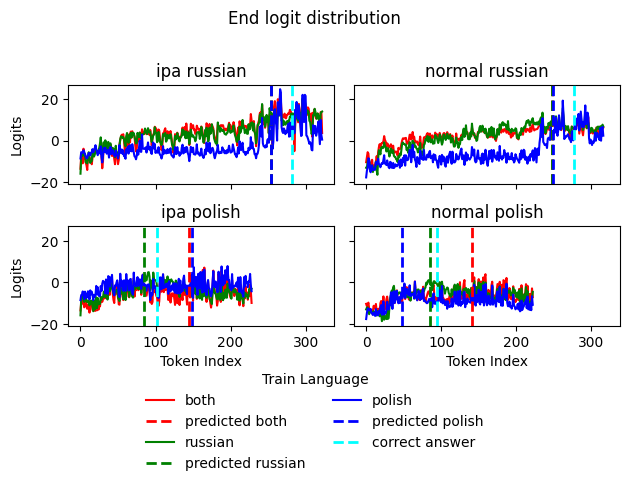

In [5]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

axes[0, 0].set_title('ipa russian')
axes[0, 1].set_title('normal russian')
axes[1, 0].set_title('ipa polish')
axes[1, 1].set_title('normal polish')

for ax in axes[:, 0]:
    ax.set_ylabel('Logits')
for ax in axes[1, :]:
    ax.set_xlabel('Token Index')

plot_lines(axes[0, 0], end_logits, 'ipa', 'russian')
plot_lines(axes[1, 0], end_logits, 'ipa', 'polish')
plot_lines(axes[0, 1], end_logits, 'normal', 'russian')
plot_lines(axes[1, 1], end_logits, 'normal', 'polish')

# Collect handles and labels from one subplot (all are the same)
handles, labels = axes[0, 0].get_legend_handles_labels()

# Create a single legend for the whole figure
fig.legend(handles, labels, title='Train Language', loc='lower center', ncol=2, frameon=False)

fig.suptitle('End logit distribution')
plt.tight_layout(rect=[0, 0.2, 1, 0.97])
plt.show()

# Analysis

It appears that the models seem to be pretty consistent across their answers, lets look at the actual prompt and compare the answers to see if that reveals anything.

## Russian

The Russian prompt is this:
> <|endoftext|> Какие химикалии добавляются к бюллетеням, чтобы дым был белым? <|endoftext|> После того, как все кардиналы проголосуют, первый член счётной комиссии перемещает контейнер, вынимает и подсчитывает бюллетени. Если количество поданных бюллетеней и количество голосовавших кардиналов не совпадает, все бюллетени не читаются и сжигаются. Если же никаких проблем с количеством нет, то голоса подсчитываются. Первый из членов счётной палаты раскрывает бюллетени. Каждый член счётной комиссии записывает имя кандидата в бюллетене, а последний — также объявляет это имя вслух. Все голоса кардиналов складываются и ревизоры проверяют все списки, чтобы не было ошибок. После объявления окончательных результатов бюллетени сжигаются членом счётной комиссии с помощью секретаря Коллегии и церемониймейстеров. В случае когда в первом туре сессии кардиналы не могут выбрать папу, они переходят к следующему немедленно и бюллетени сжигаются только после второго тура. В случае, если никто не выбран, дым чёрный (раньше к бюллетеням добавлялась мокрая солома, а с 1958 года — химикалии: смесь перхлората калия, антрацена и серы), если же новый римский епископ выбран, то идет белый дым (смесь бертолетовой соли, лактозы и канифоли[11]). Теперь, с целью избежания недоразумений, белый дым также сопровождается звоном колоколов. <|endoftext|>

The question translates to: "What chemicals are added to ballots to make the smoke white?"

The context translates to:
> After all the cardinals have voted, the first member of the counting commission moves the container, removes, and counts the ballots. If the number of ballots submitted and the number of cardinals who voted do not match, all ballots are discarded and burned. If there are no problems with the number of ballots cast, the votes are counted. The first member of the counting commission opens the ballots. Each member of the counting commission writes the name of the candidate on the ballot, and the last member also announces this name aloud. All the cardinals' votes are added up, and the auditors check all the lists to ensure there are no errors. After the final results are announced, the ballots are burned by a member of the counting commission with the assistance of the College Secretary and the masters of ceremonies. If the cardinals fail to choose a pope in the first round of a session, they move on to the next immediately, and the ballots are burned only after the second round. If no one is elected, the smoke is black (previously, wet straw was added to the ballots, and since 1958, chemicals—a mixture of potassium perchlorate, anthracene, and sulfur—are added). If a new Bishop of Rome is elected, white smoke is emitted (a mixture of potassium chlorate, lactose, and rosin[11]). Now, to avoid misunderstandings, the white smoke is also accompanied by the ringing of bells.

The accepted answer should be: "a mixture of potassium chlorate, lactose, and rosin"

The models have all predicted:

"смесь перхлората калия, антрацена и серы" > "a mixture of potassium perchlorate, anthracene and sulfur"



Looking at the start logits, it appears that this example may just be difficult. It seems perplexed as to the starting point and just generates a curve. The Polish model seems to be the most confident with peaks near both chemical list positions, but I need to verify that.

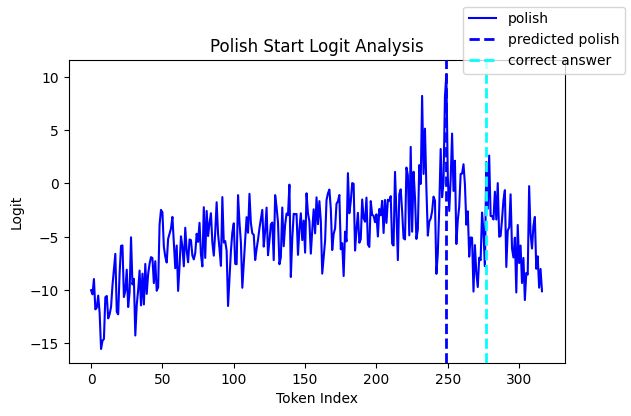

In [8]:
fig, ax = plt.subplots()

x = range(len(start_logits[f'normal-polish']['russian']))
y = start_logits[f'normal-polish']['russian']

ax.plot(x, y, label=f'polish', color='blue')
ax.axvline(x=predicted_indices[f'normal-polish']['russian'][0], zorder=3, color='blue', linestyle='--', linewidth=2, label='predicted polish')
ax.axvline(x=correct_answer['normal']['russian'][0], zorder=3, color='cyan', linestyle='--', linewidth=2, label='correct answer')

ax.set_xlabel("Token Index")
ax.set_ylabel("Logit")
ax.set_title("Polish Start Logit Analysis")

fig.legend()

plt.show()


For sake of completeness I should look at the other logits too.

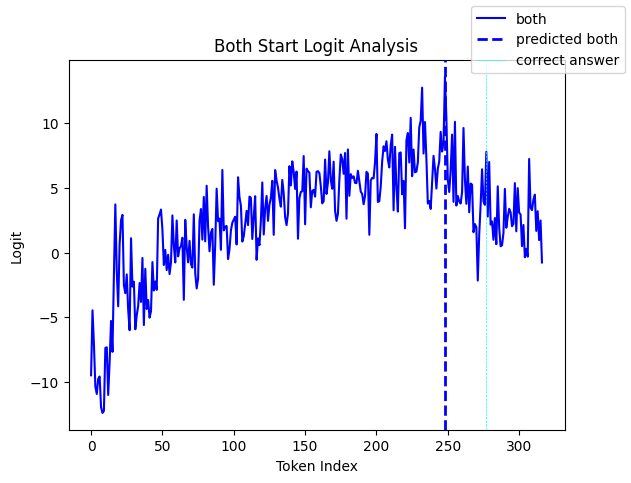

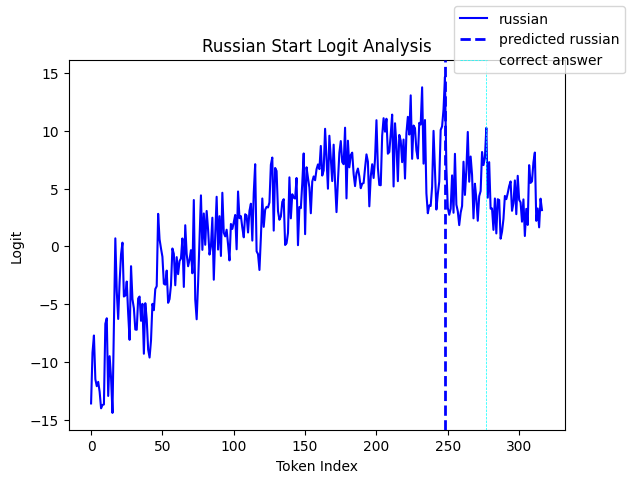

In [14]:
fig, ax = plt.subplots()

x = range(len(start_logits[f'normal-both']['russian']))
y = start_logits[f'normal-both']['russian']

ax.plot(x, y, label=f'both', color='blue')
ax.axvline(x=predicted_indices[f'normal-both']['russian'][0], zorder=3, color='blue', linestyle='--', linewidth=2, label='predicted both')
ax.axvline(x=correct_answer['normal']['russian'][0], zorder=3, color='cyan', linestyle='--', linewidth=0.5, label='correct answer')

ax.set_xlabel("Token Index")
ax.set_ylabel("Logit")
ax.set_title("Both Start Logit Analysis")

fig.legend()

fig, ax = plt.subplots()

x = range(len(start_logits[f'normal-russian']['russian']))
y = start_logits[f'normal-russian']['russian']

ax.plot(x, y, label=f'russian', color='blue')
ax.axvline(x=predicted_indices[f'normal-russian']['russian'][0], zorder=3, color='blue', linestyle='--', linewidth=2, label='predicted russian')
ax.axvline(x=correct_answer['normal']['russian'][0], zorder=3, color='cyan', linestyle='--', linewidth=0.5, label='correct answer')

ax.set_xlabel("Token Index")
ax.set_ylabel("Logit")
ax.set_title("Russian Start Logit Analysis")

fig.legend()

plt.show()

So the Polish model does see the second list of chemicals, it must just be more confident in the first one. This could be number of reasons, but more than likely, it's because of a distribution issue in the dataset. I considered that maybe I just needed to increase the top-k, but not amount of top-k is going to fix the massive confidence spike at the first liste of chemicals.

Looking at the "Both" and "Russian" models you can see a similar phenomenon where there is a spike at the second list of chemicals, but the first list dominates

I'm not sure where the upward trending curve is coming from, it is likely the model learning that the probability of the answer start increases the farther from the start of the context you get.

## Polish

For Polish the end logits seem to indicate 2 strong finish points. again, across all of the answers, the predicted indices don't seem to change a whole lot, so I inspected the actual text that was being generated.

The prompt is this:
> <|endoftext|> Jakie czynnik miał sprawiać, że niemieckie siły zbrojne nie mogły zrealizować obietnic obronnych w ramach NATO? <|endoftext|> Reforma sił zbrojnych Niemiec z 2011 r. ustanowiła wymagany poziom liczebności na 185 tys. żołnierzy i 40 tys. rezerwistów, istnieje jednak stały problem z dojściem do tego poziomu.
We wrześniu 2014 roku Bundeswehra przyznała się do przewlekłych problemów ze sprzętem, które sprawiają, że siły zbrojne nie są „w stanie dotrzymywać swoich obietnic obronnych w ramach NATO”. Wśród problemów cytowane były niesprawne systemy strzeleckie, pojazdy opancerzone, samoloty i okręty wojenne, nienadające się do natychmiastowego użycia ze względu na zaniedbania w konserwacji i poważne braki części zamiennych. Sytuacja była tak tragiczna, iż uznano że większość samolotów bojowych i śmigłowców niemieckich nie była w stanie latać. <|endoftext|>

The translated question is: "What factor was supposed to prevent the German armed forces from fulfilling their defense promises within NATO?"

The translated context is:
> The 2011 reform of the German armed forces established a required strength level of 185,000 soldiers and 40,000 reservists, but achieving this level remains a persistent challenge.
>
> In September 2014, the Bundeswehr admitted to chronic equipment problems that rendered the armed forces "unable to deliver on their NATO defense promises." Among the problems cited were inoperable gunnery systems, armored vehicles, aircraft, and warships, unsuitable for immediate use due to neglected maintenance and a serious shortage of spare parts. The situation was so dire that most German combat aircraft and helicopters were deemed inoperable.

The golden answer is: "przewlekłych problemów ze sprzętem"

Which translates to: "chronic hardware problems"

The models have all predicted something along the lines of:
* "systemy strzeleckie, pojazdy opancerzone, samoloty i okręty wojenne" > "shooting systems, armored vehicles, aircraft and warships"

It seems that this context just has 2 valid answers, because if I asked you the same question and you responded with this, I would understand what you're saying. I'm chalking this up to a dataset quality issue.